Luca Dal Zotto
1236343

# Import

In [ ]:
!pip install gym

In [ ]:
import random
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import matplotlib.patches as mpatches

from torch import nn
from collections import deque # this python module implements exactly what we need for the replay memeory

# Enable gym environment rendering in Colab

> This section is not required if you are executing the notebook in a local environment. It enables the video generation from Gym environments, and it is only required in Colab since we do not have access to a screen.

Source: https://colab.research.google.com/drive/18LdlDDT87eb8cCTHZsXyS9ksQPzL3i6H

In [ ]:
!apt update
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [44.8 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:12 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:13 https://developer.download.nvi

In [ ]:
import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor

In [ ]:
display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [ ]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_videos():
  mp4list = glob.glob('video/*.mp4')
  mp4list.sort()
  for mp4 in mp4list:
    print(f"\nSHOWING VIDEO {mp4}")
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    
def wrap_env(env, video_callable=None):
  env = Monitor(env, './video', force=True, video_callable=video_callable)
  return env

# Experience replay (Replay Memory)

In [ ]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"
        # Once a bounded length deque is full, when new items are added, a corresponding number of items are discarded from the opposite end

    def push(self, state, action, next_state, reward):
        # Add the tuple (state, action, next_state, reward) to the queue
        self.memory.append( (state, action, next_state, reward) ) 

    def sample(self, batch_size):
        # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        batch_size = min(batch_size, len(self)) 
        # Randomly select "batch_size" samples
        return random.sample(self.memory, batch_size) 

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

# Policy network

## Network definition

In [ ]:
class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        self.linear = nn.Sequential(
                nn.Linear(state_space_dim, 128),
                nn.Tanh(),
                nn.Linear(128, 128),
                nn.Tanh(),
                nn.Linear(128, action_space_dim)
                )

    def forward(self, x):
        return self.linear(x)

In [ ]:
# Define an example network
net = DQN(state_space_dim=2, action_space_dim=3)

## Exploration Policy

Starting from the estimated Q-values, we need to choose the proper action. This action may be the one expected to provide the highest long term reward (exploitation), or maybe we want to find a better policy by choosing a different action (exploration).

The exploration policy controls this behavior, typically by varying a single parameter.

Since our Q-values estimates are far from the true values at the beginning of the training, a high exploration is preferred in the initial phase.

The steps are:

`Current state -> Policy network -> Q-values -> Exploration Policy -> Action`

### Epsilon-greedy policy


With an epsilon-greedy policy we choose a **non optimal** action with probability epsilon, otherwise choose the best action (the one corresponding to the highest Q-value).

In [ ]:
def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        net_out = net(state)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.numpy()

### Softmax policy

With a softmax policy we choose the action based on a distribution obtained applying a softmax (with temperature $\tau$) to the estimated Q-values. The highest the temperature, the more the distribution will converge to a random uniform distribution. At zero temperature, instead, the policy will always choose the action with the highest Q-value.


In [ ]:
def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out / temperature, dim=0).numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) 
    # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.numpy()

### Exploration profile

I modified the exploration profile by changing the decay rate, the initial value, and also making it non-monotonic.

Monotonic case:

$$f(x)=t_{0} \cdot r a t e^{x},$$

Non-monotonic case:

$$f(x)=\frac{t_{0} \cdot r a t e^{x}+t_{0}\left[-\sin \left(\frac{\pi \cdot x}{T}\right)+1\right] \cdot r a t e_{2}^{x}}{2}.$$

In [ ]:
def exploration_profile(num_iterations, initial_value, rate=0.99, period=0, rate2=0.994):

    ep = [initial_value * (rate ** i) for i in range(num_iterations)]
    
    if period != 0:
        p = period/2
        ep = [( exp + initial_value * (-np.sin(np.pi * i/p) + 1) * (rate2 ** i))/2 for i,exp in enumerate(ep)]

    return ep

# Gym Environment (MountainCar-v0)

    Description:
        The agent (a car) is started at the bottom of a valley. For any given
        state the agent may choose to accelerate to the left, right or cease
        any acceleration.
    Observation:
        Type: Box(2)
        Num    Observation               Min            Max
        0      Car Position              -1.2           0.6
        1      Car Velocity              -0.07          0.07
    Actions:
        Type: Discrete(3)
        Num    Action
        0      Accelerate to the Left
        1      Don't accelerate
        2      Accelerate to the Right
        Note: This does not affect the amount of velocity affected by the
        gravitational pull acting on the car.
    Reward:
         Reward of 0 is awarded if the agent reached the flag (position = 0.5)
         on top of the mountain.
         Reward of -1 is awarded if the position of the agent is less than 0.5.
    Starting State:
         The position of the car is assigned a uniform random value in
         [-0.6 , -0.4].
         The starting velocity of the car is always assigned to 0.
    Episode Termination:
         The car position is more than 0.5
         Episode length is greater than 200

In [ ]:
### Create environment
env = gym.make('MountainCar-v0') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 2
ACTION SPACE SIZE: 3


## Random agent

First of all, to check that the environment is working properly, let's try with an agent which simply choose an action randomly.

In [ ]:
# Initialize the Gym environment
env = gym.make('MountainCar-v0') 
env.seed(0) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: True)

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    random.seed(1)
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done and score < 490:
        
        # Choose a random action
        action = random.choice([0, 1, 2])
        # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
        next_state, reward, done, info = env.step(action)
        # Visually render the environment (optional, comment this line to speed up the simulation)
        env.render()
        # Update the final score (+1 for each step)
        score += reward 
        # Set the current state for the next iteration
        state = next_state
        # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1:2} - FINAL SCORE: {score}") 

env.close()


EPISODE  1 - FINAL SCORE: -200.0
EPISODE  2 - FINAL SCORE: -200.0
EPISODE  3 - FINAL SCORE: -200.0
EPISODE  4 - FINAL SCORE: -200.0
EPISODE  5 - FINAL SCORE: -200.0
EPISODE  6 - FINAL SCORE: -200.0
EPISODE  7 - FINAL SCORE: -200.0
EPISODE  8 - FINAL SCORE: -200.0
EPISODE  9 - FINAL SCORE: -200.0
EPISODE 10 - FINAL SCORE: -200.0


In [ ]:
# Display the videos, not required outside Colab
show_videos()


SHOWING VIDEO video/openaigym.video.0.2173.video000000.mp4



SHOWING VIDEO video/openaigym.video.0.2173.video000001.mp4



SHOWING VIDEO video/openaigym.video.0.2173.video000002.mp4



SHOWING VIDEO video/openaigym.video.0.2173.video000003.mp4



SHOWING VIDEO video/openaigym.video.0.2173.video000004.mp4



SHOWING VIDEO video/openaigym.video.0.2173.video000005.mp4



SHOWING VIDEO video/openaigym.video.0.2173.video000006.mp4



SHOWING VIDEO video/openaigym.video.0.2173.video000007.mp4



SHOWING VIDEO video/openaigym.video.0.2173.video000008.mp4



SHOWING VIDEO video/openaigym.video.0.2173.video000009.mp4


# Network update

## Initialization

In [ ]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

### PARAMETERS
gamma = 0.97   # gamma parameter for the long term reward
replay_memory_capacity = 10000   # Replay memory capacity
lr = 1e-2   # Optimizer learning rate
target_net_update_steps = 10   # Number of episodes to wait before updating the target network
batch_size = 128   # Number of samples to take from the replay memory for each update
bad_state_penalty = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training

In [ ]:
### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

### Initialize the policy network
policy_net = DQN(state_space_dim, action_space_dim)

### Initialize the target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim)
target_net.load_state_dict(policy_net.state_dict()) 
# This will copy the weights of the policy network to the target network:
# needed because Pytorch initialize them differently

### Initialize the optimizer
optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) 
# The optimizer will update ONLY the parameters of the policy network
# NB: in RL keeping the previous directions of the gradient may not be beneficial!
# Stability is the main problem of RL...

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

## Update function

In [ ]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    states      = torch.tensor([s[0] for s in batch], dtype=torch.float32)
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32)

    # We need to distinguish between final and non-final states!
    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32) 
    # NB: we have previously set the next state to None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
        target_net.eval()
        q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]
    # future rewards will be zero for final states

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma) # these are our labels
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)
    # we are optimizing the best possible thing that we can do given our current knowledge, 
    # agaist the direct output of the network (the current policy)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2) # if the sum of the gradinets is larger than 2, we rescale them
    # This prevents the weigths to update too fast
    optimizer.step()

## Training loop

In [ ]:
min_samples_for_training = 1000 # Minimum samples in the replay memory to enable the training
batch_size = 128 # Number of samples to take from the replay memory for each update

def main(iter=1000, gamma=0.97, replay_memory_capacity=10000, lr=1e-2, target_net_update_steps=10, bad_state_penalty=0, 
         strategy='position', exp_policy='softmax', initial_value=1, rate=0.99, period=0, pos_weight=1, speed_weight=10):

    ep = exploration_profile(iter, initial_value=initial_value, rate=rate, period=period)

    # --- Set random seeds ---
    torch.manual_seed(0)
    np.random.seed(0)
    random.seed(0)

    # --- Initialize the replay memory ---
    replay_mem = ReplayMemory(replay_memory_capacity)    

    # --- Initialize the policy network ---
    policy_net = DQN(2, 3)

    # --- Initialize the target network with the same weights of the policy network ---
    target_net = DQN(2, 3)
    target_net.load_state_dict(policy_net.state_dict()) 
    # This will copy the weights of the policy network to the target network:
    # needed because Pytorch initialize them differently

    # --- Initialize the optimizer ---
    optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) 
    # The optimizer will update ONLY the parameters of the policy network
    # NB: in RL keeping the previous directions of the gradient may not be beneficial!
    # Stability is the main problem of RL...

    # --- Initialize the loss function (Huber loss) ---
    loss_fn = nn.SmoothL1Loss()

    # --- Initialize the Gym environment ---
    env = gym.make('MountainCar-v0') 
    env.seed(0) # Set a random seed for the environment (reproducible results)

    ## This is for creating the output video in Colab, not required outside Colab
    # env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes

    test_score_log = []
    best_position_log = []

    for episode_num, tau in enumerate(tqdm(ep[:iter])):

        # Reset the environment and get the initial state
        state = env.reset()
        # Reset the score. The final score will be the total amount of steps before the pole falls
        score = 200
        done = False
        # best_position = -0.5

        # Go on until the pole falls off
        while not done:

            # --- Scegliamo un'azione, facciamo uno step, modifichiamo il reward e aggiungiamo la 4-tupla alla replay memory ---
            # Choose the action following the policy
            if exp_policy == 'softmax':
                action, q_values = choose_action_softmax(policy_net, state, temperature=tau)
            elif exp_policy == 'epsilon-greedy':
                action, q_values = choose_action_epsilon_greedy(policy_net, state, epsilon=tau)
            
            # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
            next_state, reward, done, info = env.step(action)

            new_position, new_speed = next_state
            # if new_position > best_position:
            #     best_position = new_position

            # Modify reward
            # if strategy == 'right':    
            #     reward = reward + pos_weight * new_position
                            
            # elif strategy == 'height':
            #     reward = reward + pos_weight * np.abs(new_position + 0.5) 

            # elif strategy == 'speed':
            #     reward = reward + speed_weight * np.abs(new_speed)

            # elif strategy == 'right_speed':
            reward = reward + pos_weight * new_position + speed_weight * np.abs(new_speed)
            
            # elif strategy == 'em':
            #     reward = 100*((np.sin(new_position) + 0.5 * new_speed * new_speed) - (np.sin(new_position) + 0.5 * new_speed * new_speed)) 
            #     if new_position >= 0.5:
            #         reward += 1

            # Update the final score (+1 for each step)
            score -= 1

            # Apply penalty for bad state
            if done: # if the pole has fallen down 
                reward += 0
                next_state = None

            # Update the replay memory
            replay_mem.push(state, action, next_state, reward)

            # --- quando abbiamo abbastanza dati, aggiorniamo la network ---
            # Update the network
            if len(replay_mem) > min_samples_for_training: 
                # we enable the training only if we have enough samples in the replay memory, 
                # otherwise the training will use the same samples too often
                update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

            # Visually render the environment (disable to speed up the training)
            # env.render()

            # Set the current state for the next iteration
            state = next_state
        
        # Print the final score
        # print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score

        # Update the target network every target_net_update_steps = 10 episodes
        if (episode_num + 1) % target_net_update_steps == 0:
            # print('Updating target network...')
            target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

        # Test the current network for 5 episodes with temperature = 0
        if (episode_num + 1) % 50 == 0:
            # print('Test (temperature = 0)...')
            score_log = []
            position_log = []
            # Let's try for a total of 5 episodes
            for num_episode in range(3): 
                # Reset the environment and get the initial state
                state = env.reset()
                # Reset the score. The final score will be the total amount of steps before the pole falls
                score = 200
                best_position = -0.5
                done = False
                # Go on until the pole falls off or the score reach 490
                while not done:
                    # Choose the best action (temperature 0)
                    action, q_values = choose_action_softmax(policy_net, state, temperature=0)
                    # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
                    next_state, reward, done, info = env.step(action)
                    new_position = next_state[0]
                    if new_position > best_position:
                        best_position = new_position
                    # Visually render the environment
                    # env.render()
                    # Here it makes no sense to change the reward
                    # Update the final score (+1 for each step)
                    score -= 1 # or +=1
                    # Set the current state for the next iteration
                    state = next_state
                    # Check if the episode ended (the pole fell down)
                # Print the final score
                # print(f"TEST EPISODE {num_episode + 1} - FINAL SCORE: {score} - position: {best_position}") 
                score_log.append(score)
                position_log.append(best_position)
            avg_score = np.mean(score_log)
            max_position = np.max(position_log)
            print(f'After {episode_num + 1} training episodes, average test score: {avg_score:.1f}, best position: {max_position:.2f}')
            test_score_log.append(avg_score)
            best_position_log.append(max_position)
            # Early stopping
            # if avg_score == 500:
            #     print(f'Game solved after {episode_num + 1} training episodes')
            #     break

            # if episode_num == iter-1 and avg_score < 500:
            #     print(f'Game NOT solved after {episode_num + 1} training episodes. Best score: {np.max(test_score_log)}')
    
    print(f'Best score: {np.max(test_score_log)}, best position: {np.max(best_position_log)}')

    env.close()
    # return test_score_log, episode_num+1
    return test_score_log, best_position_log, episode_num+1, policy_net # if we want to further test, we need also the policy_net

In [ ]:
results = []
pbar = tqdm(total = 96, desc = 'Optimization')
for rate in [0.99, 0.995]:
  for gamma in [0.999, 0.97]:
    for initial_value in [1]:
      for period in [0]:
        for pos_weight in [1, 10]:
          for speed_weight in [10, 100]:
            for tnus in [1, 10]: # target_net_update_steps
              for lr in [1e-1, 1e-2, 1e-3]: 

                # print(f'rate: {rate}, g:{gamma}, t0: {initial_value}, T: {period}, pw:{pos_weight}, sw:{speed_weight}, tnsu: {tnus}, lr: {lr}')
                # key = f'b:{rate}, g:{gamma}, t0:{initial_value}, T:{period}, pw:{pos_weight}, sw:{speed_weight}, ts:{tnus}, lr:{lr}'
                print(f'rate: {rate}, g:{gamma}, pw:{pos_weight}, sw:{speed_weight}, tnsu: {tnus}, lr: {lr}')
                key = f'b:{rate}, g:{gamma}, pw:{pos_weight}, sw:{speed_weight}, ts:{tnus}, lr:{lr}'

                score_log, position_log, ep_num, _ = main(iter=1000, gamma=gamma, replay_memory_capacity=5000, lr=lr, target_net_update_steps=tnus, 
                                        bad_state_penalty=0, strategy='right_speed', exp_policy='softmax', initial_value=initial_value,
                                        rate=rate, period=period, pos_weight=pos_weight, speed_weight=speed_weight)
                results.append((key, ep_num, score_log, position_log))
                print()
                pbar.update(1)

rate: 0.99, g:0.999, pw:1, sw:10, tnsu: 1, lr: 0.1


After 50 training episodes, average test score: 0.0, best position: -0.42
After 100 training episodes, average test score: 0.0, best position: -0.43
After 150 training episodes, average test score: 0.0, best position: -0.45
After 200 training episodes, average test score: 0.0, best position: -0.22
After 250 training episodes, average test score: 0.0, best position: -0.23
After 300 training episodes, average test score: 0.0, best position: -0.27
After 350 training episodes, average test score: 0.0, best position: -0.30
After 400 training episodes, average test score: 0.0, best position: -0.19
After 450 training episodes, average test score: 0.0, best position: -0.19
After 500 training episodes, average test score: 0.0, best position: -0.21
After 550 training episodes, average test score: 0.0, best position: -0.31
After 600 training episodes, average test score: 0.0, best position: -0.23
After 650 training episodes, average test score: 0.0, best position: -0.32
After 700 training episode

After 50 training episodes, average test score: 0.0, best position: -0.42
After 100 training episodes, average test score: 0.0, best position: -0.42
After 150 training episodes, average test score: 0.0, best position: -0.28
After 200 training episodes, average test score: 0.0, best position: -0.22
After 250 training episodes, average test score: 0.0, best position: -0.23
After 300 training episodes, average test score: 0.0, best position: -0.10
After 350 training episodes, average test score: 0.0, best position: -0.30
After 400 training episodes, average test score: 0.0, best position: -0.19
After 450 training episodes, average test score: 15.7, best position: 0.52
After 500 training episodes, average test score: 0.0, best position: -0.21
After 550 training episodes, average test score: 0.0, best position: -0.31
After 600 training episodes, average test score: 0.0, best position: -0.34
After 650 training episodes, average test score: 0.0, best position: -0.41
After 700 training episode

After 50 training episodes, average test score: 0.0, best position: -0.42
After 100 training episodes, average test score: 0.0, best position: -0.43
After 150 training episodes, average test score: 0.0, best position: -0.28
After 200 training episodes, average test score: 0.0, best position: -0.41
After 250 training episodes, average test score: 0.0, best position: -0.43
After 300 training episodes, average test score: 0.0, best position: -0.19
After 350 training episodes, average test score: 0.0, best position: -0.30
After 400 training episodes, average test score: 0.0, best position: -0.19
After 450 training episodes, average test score: 0.0, best position: -0.19
After 500 training episodes, average test score: 0.0, best position: -0.21
After 550 training episodes, average test score: 0.0, best position: -0.31
After 600 training episodes, average test score: 0.0, best position: -0.23
After 650 training episodes, average test score: 0.0, best position: -0.32
After 700 training episode

After 50 training episodes, average test score: 2.7, best position: 0.51
After 100 training episodes, average test score: 6.0, best position: 0.50
After 150 training episodes, average test score: 0.0, best position: -0.28
After 200 training episodes, average test score: 0.0, best position: -0.22
After 250 training episodes, average test score: 0.0, best position: -0.41
After 300 training episodes, average test score: 0.0, best position: -0.25
After 350 training episodes, average test score: 0.0, best position: -0.30
After 400 training episodes, average test score: 0.0, best position: -0.27
After 450 training episodes, average test score: 0.0, best position: -0.25
After 500 training episodes, average test score: 0.0, best position: -0.45
After 550 training episodes, average test score: 0.0, best position: -0.41
After 600 training episodes, average test score: 0.0, best position: -0.36
After 650 training episodes, average test score: 0.0, best position: -0.32
After 700 training episodes,

After 50 training episodes, average test score: 0.0, best position: -0.33
After 100 training episodes, average test score: 0.0, best position: -0.43
After 150 training episodes, average test score: 0.0, best position: -0.28
After 200 training episodes, average test score: 0.0, best position: -0.22
After 250 training episodes, average test score: 0.0, best position: -0.23
After 300 training episodes, average test score: 0.0, best position: -0.19
After 350 training episodes, average test score: 0.0, best position: -0.30
After 400 training episodes, average test score: 0.0, best position: -0.19
After 450 training episodes, average test score: 0.0, best position: -0.19
After 500 training episodes, average test score: 0.0, best position: -0.21
After 550 training episodes, average test score: 0.0, best position: -0.31
After 600 training episodes, average test score: 0.0, best position: -0.23
After 650 training episodes, average test score: 0.0, best position: -0.32
After 700 training episode

After 50 training episodes, average test score: 0.0, best position: -0.42
After 100 training episodes, average test score: 0.0, best position: -0.38
After 150 training episodes, average test score: 0.0, best position: -0.41
After 200 training episodes, average test score: 0.0, best position: -0.37
After 250 training episodes, average test score: 0.0, best position: -0.40
After 300 training episodes, average test score: 0.0, best position: -0.39
After 350 training episodes, average test score: 0.0, best position: -0.39
After 400 training episodes, average test score: 0.0, best position: -0.39
After 450 training episodes, average test score: 0.0, best position: -0.45
After 500 training episodes, average test score: 0.0, best position: -0.21
After 550 training episodes, average test score: 0.0, best position: -0.38
After 600 training episodes, average test score: 0.0, best position: -0.32
After 650 training episodes, average test score: 0.0, best position: -0.41
After 700 training episode

After 50 training episodes, average test score: 0.0, best position: -0.42
After 100 training episodes, average test score: 0.0, best position: -0.27
After 150 training episodes, average test score: 0.0, best position: -0.28
After 200 training episodes, average test score: 0.0, best position: -0.23
After 250 training episodes, average test score: 0.0, best position: -0.34
After 300 training episodes, average test score: 0.0, best position: -0.27
After 350 training episodes, average test score: 0.0, best position: -0.42
After 400 training episodes, average test score: 0.0, best position: -0.32
After 450 training episodes, average test score: 0.0, best position: -0.41
After 500 training episodes, average test score: 0.0, best position: -0.45
After 550 training episodes, average test score: 0.0, best position: -0.35
After 600 training episodes, average test score: 0.0, best position: -0.32
After 650 training episodes, average test score: 0.0, best position: -0.38
After 700 training episode

After 50 training episodes, average test score: 0.0, best position: -0.42
After 100 training episodes, average test score: 0.0, best position: -0.20
After 150 training episodes, average test score: 0.0, best position: -0.28
After 200 training episodes, average test score: 0.0, best position: -0.22
After 250 training episodes, average test score: 0.0, best position: -0.23
After 300 training episodes, average test score: 0.0, best position: -0.19
After 350 training episodes, average test score: 0.0, best position: -0.22
After 400 training episodes, average test score: 0.0, best position: -0.32
After 450 training episodes, average test score: 0.0, best position: -0.35
After 500 training episodes, average test score: 0.0, best position: -0.21
After 550 training episodes, average test score: 39.0, best position: 0.52
After 600 training episodes, average test score: 0.0, best position: 0.37
After 650 training episodes, average test score: 0.0, best position: -0.32
After 700 training episodes

After 50 training episodes, average test score: 0.0, best position: -0.42
After 100 training episodes, average test score: 0.0, best position: -0.27
After 150 training episodes, average test score: 0.0, best position: -0.28
After 200 training episodes, average test score: 0.0, best position: -0.41
After 250 training episodes, average test score: 0.0, best position: -0.43
After 300 training episodes, average test score: 0.0, best position: -0.19
After 350 training episodes, average test score: 0.0, best position: -0.42
After 400 training episodes, average test score: 0.0, best position: -0.19
After 450 training episodes, average test score: 0.0, best position: -0.19
After 500 training episodes, average test score: 0.0, best position: -0.21
After 550 training episodes, average test score: 0.0, best position: -0.31
After 600 training episodes, average test score: 0.0, best position: -0.41
After 650 training episodes, average test score: 0.0, best position: -0.41
After 700 training episode

After 50 training episodes, average test score: 0.0, best position: -0.30
After 100 training episodes, average test score: 0.0, best position: -0.11
After 150 training episodes, average test score: 28.0, best position: 0.52
After 200 training episodes, average test score: 48.0, best position: 0.54
After 250 training episodes, average test score: 0.0, best position: -0.23
After 300 training episodes, average test score: 46.3, best position: 0.54
After 350 training episodes, average test score: 94.0, best position: 0.53
After 400 training episodes, average test score: 53.7, best position: 0.54
After 450 training episodes, average test score: 65.7, best position: 0.54
After 500 training episodes, average test score: 58.3, best position: 0.54
After 550 training episodes, average test score: 0.0, best position: -0.31
After 600 training episodes, average test score: 70.3, best position: 0.54
After 650 training episodes, average test score: 6.7, best position: 0.54
After 700 training episodes

After 50 training episodes, average test score: 0.0, best position: -0.42
After 100 training episodes, average test score: 0.0, best position: -0.43
After 150 training episodes, average test score: 0.0, best position: -0.28
After 200 training episodes, average test score: 0.0, best position: -0.22
After 250 training episodes, average test score: 0.0, best position: -0.43
After 300 training episodes, average test score: 0.0, best position: -0.19
After 350 training episodes, average test score: 0.0, best position: -0.30
After 400 training episodes, average test score: 0.0, best position: 0.30
After 450 training episodes, average test score: 79.7, best position: 0.51
After 500 training episodes, average test score: 92.0, best position: 0.54
After 550 training episodes, average test score: 112.0, best position: 0.52
After 600 training episodes, average test score: 84.3, best position: 0.54
After 650 training episodes, average test score: 64.7, best position: 0.54
After 700 training episode

After 50 training episodes, average test score: 0.0, best position: -0.42
After 100 training episodes, average test score: 0.0, best position: -0.37
After 150 training episodes, average test score: 0.0, best position: -0.31
After 200 training episodes, average test score: 0.0, best position: -0.37
After 250 training episodes, average test score: 0.0, best position: -0.40
After 300 training episodes, average test score: 0.0, best position: -0.50
After 350 training episodes, average test score: 0.0, best position: -0.42
After 400 training episodes, average test score: 0.0, best position: -0.42
After 450 training episodes, average test score: 0.0, best position: -0.45
After 500 training episodes, average test score: 0.0, best position: -0.45
After 550 training episodes, average test score: 0.0, best position: -0.31
After 600 training episodes, average test score: 0.0, best position: -0.41
After 650 training episodes, average test score: 0.0, best position: -0.41
After 700 training episode

After 50 training episodes, average test score: 0.0, best position: -0.27
After 100 training episodes, average test score: 0.0, best position: -0.20
After 150 training episodes, average test score: 0.0, best position: -0.28
After 200 training episodes, average test score: 0.0, best position: -0.28
After 250 training episodes, average test score: 0.0, best position: -0.35
After 300 training episodes, average test score: 0.0, best position: -0.38
After 350 training episodes, average test score: 0.0, best position: -0.42
After 400 training episodes, average test score: 0.0, best position: -0.38
After 450 training episodes, average test score: 0.0, best position: -0.36
After 500 training episodes, average test score: 0.0, best position: -0.43
After 550 training episodes, average test score: 0.0, best position: -0.41
After 600 training episodes, average test score: 0.0, best position: -0.36
After 650 training episodes, average test score: 0.0, best position: -0.34
After 700 training episode

After 50 training episodes, average test score: 0.0, best position: -0.17
After 100 training episodes, average test score: 0.0, best position: -0.20
After 150 training episodes, average test score: 0.0, best position: -0.15
After 200 training episodes, average test score: 0.0, best position: -0.22
After 250 training episodes, average test score: 0.0, best position: -0.34
After 300 training episodes, average test score: 0.0, best position: -0.19
After 350 training episodes, average test score: 0.0, best position: -0.30
After 400 training episodes, average test score: 0.0, best position: -0.07
After 450 training episodes, average test score: 0.0, best position: -0.19
After 500 training episodes, average test score: 37.0, best position: 0.53
After 550 training episodes, average test score: 0.0, best position: -0.31
After 600 training episodes, average test score: 67.7, best position: 0.54
After 650 training episodes, average test score: 0.0, best position: -0.32
After 700 training episode

After 50 training episodes, average test score: 0.0, best position: -0.17
After 100 training episodes, average test score: 0.0, best position: -0.43
After 150 training episodes, average test score: 0.0, best position: -0.45
After 200 training episodes, average test score: 0.0, best position: -0.41
After 250 training episodes, average test score: 0.0, best position: -0.23
After 300 training episodes, average test score: 0.0, best position: -0.48
After 350 training episodes, average test score: 0.0, best position: -0.42
After 400 training episodes, average test score: 0.0, best position: -0.19
After 450 training episodes, average test score: 0.0, best position: -0.45
After 500 training episodes, average test score: 0.0, best position: -0.45
After 550 training episodes, average test score: 0.0, best position: -0.31
After 600 training episodes, average test score: 0.0, best position: -0.23
After 650 training episodes, average test score: 0.0, best position: -0.41
After 700 training episode

After 50 training episodes, average test score: 0.0, best position: -0.42
After 100 training episodes, average test score: 0.0, best position: -0.20
After 150 training episodes, average test score: 0.0, best position: -0.28
After 200 training episodes, average test score: 0.0, best position: -0.25
After 250 training episodes, average test score: 0.0, best position: -0.31
After 300 training episodes, average test score: 0.0, best position: -0.46
After 350 training episodes, average test score: 0.0, best position: -0.42
After 400 training episodes, average test score: 0.0, best position: -0.42
After 450 training episodes, average test score: 0.0, best position: -0.41
After 500 training episodes, average test score: 0.0, best position: -0.44
After 550 training episodes, average test score: 0.0, best position: -0.41
After 600 training episodes, average test score: 0.0, best position: -0.41
After 650 training episodes, average test score: 0.0, best position: -0.41
After 700 training episode

After 50 training episodes, average test score: 0.0, best position: -0.17
After 100 training episodes, average test score: 0.0, best position: -0.20
After 150 training episodes, average test score: 0.0, best position: -0.28
After 200 training episodes, average test score: 0.0, best position: -0.22
After 250 training episodes, average test score: 0.0, best position: -0.23
After 300 training episodes, average test score: 0.0, best position: -0.06
After 350 training episodes, average test score: 0.0, best position: -0.30
After 400 training episodes, average test score: 0.0, best position: 0.05
After 450 training episodes, average test score: 0.0, best position: 0.02
After 500 training episodes, average test score: 0.0, best position: -0.21
After 550 training episodes, average test score: 0.0, best position: -0.31
After 600 training episodes, average test score: 3.3, best position: 0.53
After 650 training episodes, average test score: 0.0, best position: 0.05
After 700 training episodes, a

After 50 training episodes, average test score: 0.0, best position: -0.39
After 100 training episodes, average test score: 0.0, best position: -0.28
After 150 training episodes, average test score: 0.0, best position: -0.40
After 200 training episodes, average test score: 0.0, best position: -0.22
After 250 training episodes, average test score: 0.0, best position: -0.23
After 300 training episodes, average test score: 0.0, best position: -0.48
After 350 training episodes, average test score: 0.0, best position: -0.30
After 400 training episodes, average test score: 0.0, best position: -0.19
After 450 training episodes, average test score: 0.0, best position: -0.19
After 500 training episodes, average test score: 0.0, best position: -0.21
After 550 training episodes, average test score: 0.0, best position: -0.31
After 600 training episodes, average test score: 0.0, best position: -0.23
After 650 training episodes, average test score: 0.0, best position: -0.32
After 700 training episode

After 50 training episodes, average test score: 0.0, best position: -0.35
After 100 training episodes, average test score: 0.0, best position: -0.20
After 150 training episodes, average test score: 0.0, best position: -0.28
After 200 training episodes, average test score: 0.0, best position: -0.41
After 250 training episodes, average test score: 0.0, best position: -0.23
After 300 training episodes, average test score: 0.0, best position: -0.35
After 350 training episodes, average test score: 0.0, best position: -0.30
After 400 training episodes, average test score: 0.0, best position: -0.19
After 450 training episodes, average test score: 0.0, best position: -0.23
After 500 training episodes, average test score: 0.0, best position: -0.33
After 550 training episodes, average test score: 0.0, best position: -0.22
After 600 training episodes, average test score: 0.0, best position: -0.31
After 650 training episodes, average test score: 0.0, best position: -0.32
After 700 training episode

After 50 training episodes, average test score: 0.0, best position: -0.17
After 100 training episodes, average test score: 0.0, best position: -0.20
After 150 training episodes, average test score: 0.0, best position: -0.28
After 200 training episodes, average test score: 0.0, best position: 0.24
After 250 training episodes, average test score: 0.0, best position: -0.29
After 300 training episodes, average test score: 0.0, best position: -0.48
After 350 training episodes, average test score: 0.0, best position: -0.31
After 400 training episodes, average test score: 0.0, best position: -0.42
After 450 training episodes, average test score: 0.0, best position: -0.45
After 500 training episodes, average test score: 0.0, best position: -0.20
After 550 training episodes, average test score: 0.0, best position: 0.08
After 600 training episodes, average test score: 0.0, best position: -0.23
After 650 training episodes, average test score: 0.0, best position: -0.32
After 700 training episodes,

After 50 training episodes, average test score: 0.0, best position: -0.17
After 100 training episodes, average test score: 0.0, best position: -0.43
After 150 training episodes, average test score: 0.0, best position: -0.45
After 200 training episodes, average test score: 0.0, best position: -0.41
After 250 training episodes, average test score: 0.0, best position: -0.23
After 300 training episodes, average test score: 0.0, best position: -0.48
After 350 training episodes, average test score: 0.0, best position: -0.42
After 400 training episodes, average test score: 0.0, best position: -0.19
After 450 training episodes, average test score: 0.0, best position: -0.19
After 500 training episodes, average test score: 0.0, best position: -0.45
After 550 training episodes, average test score: 0.0, best position: -0.41
After 600 training episodes, average test score: 0.0, best position: -0.23
After 650 training episodes, average test score: 0.0, best position: -0.32
After 700 training episode

After 50 training episodes, average test score: 0.0, best position: -0.29
After 100 training episodes, average test score: 0.0, best position: -0.20
After 150 training episodes, average test score: 0.0, best position: -0.28
After 200 training episodes, average test score: 0.0, best position: -0.22
After 250 training episodes, average test score: 0.0, best position: -0.33
After 300 training episodes, average test score: 0.0, best position: -0.35
After 350 training episodes, average test score: 0.0, best position: -0.42
After 400 training episodes, average test score: 0.0, best position: -0.41
After 450 training episodes, average test score: 0.0, best position: -0.45
After 500 training episodes, average test score: 0.0, best position: -0.43
After 550 training episodes, average test score: 0.0, best position: -0.41
After 600 training episodes, average test score: 0.0, best position: -0.41
After 650 training episodes, average test score: 0.0, best position: -0.32
After 700 training episode

After 50 training episodes, average test score: 0.0, best position: -0.17
After 100 training episodes, average test score: 0.0, best position: -0.20
After 150 training episodes, average test score: 0.0, best position: -0.28
After 200 training episodes, average test score: 0.0, best position: -0.22
After 250 training episodes, average test score: 0.0, best position: -0.23
After 300 training episodes, average test score: 0.0, best position: -0.19
After 350 training episodes, average test score: 0.0, best position: -0.30
After 400 training episodes, average test score: 0.0, best position: 0.07
After 450 training episodes, average test score: 69.0, best position: 0.51
After 500 training episodes, average test score: 84.3, best position: 0.52
After 550 training episodes, average test score: 70.0, best position: 0.54
After 600 training episodes, average test score: 49.0, best position: 0.53
After 650 training episodes, average test score: 0.0, best position: 0.13
After 700 training episodes,

After 50 training episodes, average test score: 0.0, best position: -0.42
After 100 training episodes, average test score: 0.0, best position: -0.28
After 150 training episodes, average test score: 0.0, best position: -0.39
After 200 training episodes, average test score: 0.0, best position: -0.22
After 250 training episodes, average test score: 0.0, best position: -0.23
After 300 training episodes, average test score: 0.0, best position: -0.27
After 350 training episodes, average test score: 0.0, best position: -0.30
After 400 training episodes, average test score: 0.0, best position: -0.19
After 450 training episodes, average test score: 0.0, best position: -0.24
After 500 training episodes, average test score: 0.0, best position: -0.21
After 550 training episodes, average test score: 0.0, best position: -0.31
After 600 training episodes, average test score: 0.0, best position: -0.23
After 650 training episodes, average test score: 0.0, best position: -0.32
After 700 training episode

After 50 training episodes, average test score: 0.0, best position: -0.18
After 100 training episodes, average test score: 0.0, best position: -0.20
After 150 training episodes, average test score: 0.0, best position: -0.28
After 200 training episodes, average test score: 0.0, best position: -0.34
After 250 training episodes, average test score: 0.0, best position: -0.32
After 300 training episodes, average test score: 0.0, best position: -0.34
After 350 training episodes, average test score: 0.0, best position: -0.41
After 400 training episodes, average test score: 0.0, best position: -0.33
After 450 training episodes, average test score: 0.0, best position: -0.45
After 500 training episodes, average test score: 0.0, best position: -0.39
After 550 training episodes, average test score: 0.0, best position: -0.41
After 600 training episodes, average test score: 0.0, best position: -0.41
After 650 training episodes, average test score: 0.0, best position: -0.32
After 700 training episode

After 50 training episodes, average test score: 0.0, best position: -0.42
After 100 training episodes, average test score: 0.0, best position: -0.20
After 150 training episodes, average test score: 0.0, best position: -0.28
After 200 training episodes, average test score: 0.0, best position: -0.22
After 250 training episodes, average test score: 0.0, best position: -0.23
After 300 training episodes, average test score: 0.0, best position: -0.19
After 350 training episodes, average test score: 1.3, best position: 0.54
After 400 training episodes, average test score: 36.3, best position: 0.52
After 450 training episodes, average test score: 11.0, best position: 0.50
After 500 training episodes, average test score: 10.0, best position: 0.51
After 550 training episodes, average test score: 21.7, best position: 0.51
After 600 training episodes, average test score: 0.0, best position: 0.24
After 650 training episodes, average test score: 43.3, best position: 0.51
After 700 training episodes,

After 50 training episodes, average test score: 0.0, best position: -0.42
After 100 training episodes, average test score: 0.0, best position: -0.40
After 150 training episodes, average test score: 0.0, best position: -0.41
After 200 training episodes, average test score: 0.0, best position: -0.37
After 250 training episodes, average test score: 0.0, best position: -0.41
After 300 training episodes, average test score: 0.0, best position: -0.37
After 350 training episodes, average test score: 0.0, best position: -0.41
After 400 training episodes, average test score: 0.0, best position: -0.42
After 450 training episodes, average test score: 0.0, best position: -0.45
After 500 training episodes, average test score: 0.0, best position: -0.45
After 550 training episodes, average test score: 0.0, best position: -0.41
After 600 training episodes, average test score: 0.0, best position: -0.41
After 650 training episodes, average test score: 0.0, best position: -0.40
After 700 training episode

After 50 training episodes, average test score: 0.0, best position: 0.05
After 100 training episodes, average test score: 0.0, best position: -0.43
After 150 training episodes, average test score: 0.0, best position: -0.28
After 200 training episodes, average test score: 0.0, best position: -0.37
After 250 training episodes, average test score: 0.0, best position: -0.43
After 300 training episodes, average test score: 0.0, best position: -0.48
After 350 training episodes, average test score: 0.0, best position: -0.30
After 400 training episodes, average test score: 0.0, best position: -0.30
After 450 training episodes, average test score: 0.0, best position: -0.40
After 500 training episodes, average test score: 0.0, best position: -0.45
After 550 training episodes, average test score: 0.0, best position: -0.41
After 600 training episodes, average test score: 0.0, best position: -0.41
After 650 training episodes, average test score: 0.0, best position: -0.32
After 700 training episodes

After 50 training episodes, average test score: 0.0, best position: -0.33
After 100 training episodes, average test score: 0.0, best position: -0.43
After 150 training episodes, average test score: 0.0, best position: -0.28
After 200 training episodes, average test score: 0.0, best position: -0.22
After 250 training episodes, average test score: 0.0, best position: -0.23
After 300 training episodes, average test score: 0.0, best position: -0.19
After 350 training episodes, average test score: 0.0, best position: -0.30
After 400 training episodes, average test score: 0.0, best position: -0.19
After 450 training episodes, average test score: 0.0, best position: -0.19
After 500 training episodes, average test score: 0.0, best position: -0.21
After 550 training episodes, average test score: 0.0, best position: -0.31
After 600 training episodes, average test score: 0.0, best position: -0.23
After 650 training episodes, average test score: 0.0, best position: -0.32
After 700 training episode

After 50 training episodes, average test score: 0.0, best position: -0.42
After 100 training episodes, average test score: 0.0, best position: -0.38
After 150 training episodes, average test score: 0.0, best position: -0.41
After 200 training episodes, average test score: 0.0, best position: -0.37
After 250 training episodes, average test score: 0.0, best position: -0.40
After 300 training episodes, average test score: 0.0, best position: -0.38
After 350 training episodes, average test score: 0.0, best position: -0.39
After 400 training episodes, average test score: 0.0, best position: -0.42
After 450 training episodes, average test score: 0.0, best position: -0.45
After 500 training episodes, average test score: 0.0, best position: -0.24
After 550 training episodes, average test score: 0.0, best position: -0.40
After 600 training episodes, average test score: 0.0, best position: -0.40
After 650 training episodes, average test score: 0.0, best position: -0.41
After 700 training episode

After 50 training episodes, average test score: 0.0, best position: -0.42
After 100 training episodes, average test score: 0.0, best position: -0.20
After 150 training episodes, average test score: 10.7, best position: 0.53
After 200 training episodes, average test score: 26.0, best position: 0.51
After 250 training episodes, average test score: 50.7, best position: 0.54
After 300 training episodes, average test score: 44.0, best position: 0.53
After 350 training episodes, average test score: 52.7, best position: 0.54
After 400 training episodes, average test score: 31.0, best position: 0.52
After 450 training episodes, average test score: 54.0, best position: 0.51
After 500 training episodes, average test score: 57.3, best position: 0.54
After 550 training episodes, average test score: 49.0, best position: 0.54
After 600 training episodes, average test score: 43.7, best position: 0.51
After 650 training episodes, average test score: 58.0, best position: 0.52
After 700 training episode

After 50 training episodes, average test score: 0.0, best position: -0.42
After 100 training episodes, average test score: 0.0, best position: -0.20
After 150 training episodes, average test score: 0.0, best position: -0.28
After 200 training episodes, average test score: 0.0, best position: -0.22
After 250 training episodes, average test score: 0.0, best position: -0.23
After 300 training episodes, average test score: 48.3, best position: 0.54
After 350 training episodes, average test score: 66.7, best position: 0.54
After 400 training episodes, average test score: 72.3, best position: 0.54
After 450 training episodes, average test score: 61.7, best position: 0.54
After 500 training episodes, average test score: 67.0, best position: 0.54
After 550 training episodes, average test score: 63.7, best position: 0.54
After 600 training episodes, average test score: 26.3, best position: 0.54
After 650 training episodes, average test score: 61.7, best position: 0.52
After 700 training episode

After 50 training episodes, average test score: 0.0, best position: -0.42
After 100 training episodes, average test score: 0.0, best position: -0.37
After 150 training episodes, average test score: 0.0, best position: -0.29
After 200 training episodes, average test score: 0.0, best position: -0.36
After 250 training episodes, average test score: 0.0, best position: -0.43
After 300 training episodes, average test score: 0.0, best position: -0.50
After 350 training episodes, average test score: 0.0, best position: -0.42
After 400 training episodes, average test score: 0.0, best position: -0.42
After 450 training episodes, average test score: 0.0, best position: -0.45
After 500 training episodes, average test score: 0.0, best position: -0.45
After 550 training episodes, average test score: 0.0, best position: -0.41
After 600 training episodes, average test score: 0.0, best position: -0.41
After 650 training episodes, average test score: 0.0, best position: -0.41
After 700 training episode

After 50 training episodes, average test score: 0.0, best position: -0.30
After 100 training episodes, average test score: 51.3, best position: 0.51
After 150 training episodes, average test score: 0.0, best position: -0.28
After 200 training episodes, average test score: 52.3, best position: 0.55
After 250 training episodes, average test score: 77.0, best position: 0.54
After 300 training episodes, average test score: 53.7, best position: 0.52
After 350 training episodes, average test score: 72.0, best position: 0.54
After 400 training episodes, average test score: 52.7, best position: 0.54
After 450 training episodes, average test score: 70.0, best position: 0.54
After 500 training episodes, average test score: 59.0, best position: 0.51
After 550 training episodes, average test score: 78.7, best position: 0.54
After 600 training episodes, average test score: 62.7, best position: 0.54
After 650 training episodes, average test score: 0.0, best position: -0.32
After 700 training episode

After 50 training episodes, average test score: 0.0, best position: -0.42
After 100 training episodes, average test score: 0.0, best position: -0.43
After 150 training episodes, average test score: 0.0, best position: -0.28
After 200 training episodes, average test score: 0.0, best position: -0.22
After 250 training episodes, average test score: 0.0, best position: -0.40
After 300 training episodes, average test score: 0.0, best position: -0.19
After 350 training episodes, average test score: 0.0, best position: -0.22
After 400 training episodes, average test score: 88.7, best position: 0.54
After 450 training episodes, average test score: 84.7, best position: 0.54
After 500 training episodes, average test score: 72.0, best position: 0.54
After 550 training episodes, average test score: 92.3, best position: 0.54
After 600 training episodes, average test score: 97.7, best position: 0.53
After 650 training episodes, average test score: 68.3, best position: 0.54
After 700 training episode

After 50 training episodes, average test score: 0.0, best position: -0.42
After 100 training episodes, average test score: 0.0, best position: -0.37
After 150 training episodes, average test score: 0.0, best position: -0.30
After 200 training episodes, average test score: 0.0, best position: -0.34
After 250 training episodes, average test score: 0.0, best position: -0.38
After 300 training episodes, average test score: 0.0, best position: -0.48
After 350 training episodes, average test score: 0.0, best position: -0.42
After 400 training episodes, average test score: 0.0, best position: -0.42
After 450 training episodes, average test score: 0.0, best position: -0.45
After 500 training episodes, average test score: 0.0, best position: -0.45
After 550 training episodes, average test score: 0.0, best position: -0.41
After 600 training episodes, average test score: 0.0, best position: -0.41
After 650 training episodes, average test score: 0.0, best position: -0.41
After 700 training episode

After 50 training episodes, average test score: 0.0, best position: -0.19
After 100 training episodes, average test score: 0.0, best position: -0.26
After 150 training episodes, average test score: 0.0, best position: -0.30
After 200 training episodes, average test score: 0.0, best position: -0.22
After 250 training episodes, average test score: 0.0, best position: -0.28
After 300 training episodes, average test score: 0.0, best position: -0.34
After 350 training episodes, average test score: 0.0, best position: -0.30
After 400 training episodes, average test score: 0.0, best position: -0.38
After 450 training episodes, average test score: 0.0, best position: -0.37
After 500 training episodes, average test score: 0.0, best position: -0.33
After 550 training episodes, average test score: 0.0, best position: -0.31
After 600 training episodes, average test score: 0.0, best position: -0.23
After 650 training episodes, average test score: 0.0, best position: -0.32
After 700 training episode

After 50 training episodes, average test score: 0.0, best position: -0.17
After 100 training episodes, average test score: 0.0, best position: -0.20
After 150 training episodes, average test score: 0.0, best position: -0.28
After 200 training episodes, average test score: 0.0, best position: -0.22
After 250 training episodes, average test score: 0.0, best position: -0.23
After 300 training episodes, average test score: 0.0, best position: -0.19
After 350 training episodes, average test score: 0.0, best position: -0.30
After 400 training episodes, average test score: 0.0, best position: -0.19
After 450 training episodes, average test score: 0.0, best position: -0.19
After 500 training episodes, average test score: 0.0, best position: -0.21
After 550 training episodes, average test score: 0.0, best position: -0.31
After 600 training episodes, average test score: 0.0, best position: -0.23
After 650 training episodes, average test score: 0.0, best position: -0.32
After 700 training episode

After 50 training episodes, average test score: 0.0, best position: -0.17
After 100 training episodes, average test score: 0.0, best position: -0.20
After 150 training episodes, average test score: 0.0, best position: -0.45
After 200 training episodes, average test score: 0.0, best position: -0.22
After 250 training episodes, average test score: 0.0, best position: -0.37
After 300 training episodes, average test score: 0.0, best position: -0.19
After 350 training episodes, average test score: 0.0, best position: -0.30
After 400 training episodes, average test score: 0.0, best position: -0.19
After 450 training episodes, average test score: 0.0, best position: -0.19
After 500 training episodes, average test score: 0.0, best position: -0.21
After 550 training episodes, average test score: 0.0, best position: -0.31
After 600 training episodes, average test score: 0.0, best position: -0.23
After 650 training episodes, average test score: 0.0, best position: -0.32
After 700 training episode

After 50 training episodes, average test score: 0.0, best position: -0.17
After 100 training episodes, average test score: 0.0, best position: -0.20
After 150 training episodes, average test score: 0.0, best position: -0.28
After 200 training episodes, average test score: 0.0, best position: -0.41
After 250 training episodes, average test score: 0.0, best position: -0.43
After 300 training episodes, average test score: 0.0, best position: -0.40
After 350 training episodes, average test score: 0.0, best position: -0.42
After 400 training episodes, average test score: 0.0, best position: -0.42
After 450 training episodes, average test score: 0.0, best position: -0.45
After 500 training episodes, average test score: 0.0, best position: -0.43
After 550 training episodes, average test score: 0.0, best position: -0.41
After 600 training episodes, average test score: 0.0, best position: -0.27
After 650 training episodes, average test score: 0.0, best position: -0.32
After 700 training episode

After 50 training episodes, average test score: 0.0, best position: -0.17
After 100 training episodes, average test score: 0.0, best position: -0.20
After 150 training episodes, average test score: 0.0, best position: -0.28
After 200 training episodes, average test score: 0.0, best position: -0.22
After 250 training episodes, average test score: 0.0, best position: -0.23
After 300 training episodes, average test score: 0.0, best position: -0.19
After 350 training episodes, average test score: 0.0, best position: -0.30
After 400 training episodes, average test score: 0.0, best position: -0.19
After 450 training episodes, average test score: 0.0, best position: 0.09
After 500 training episodes, average test score: 0.0, best position: -0.21
After 550 training episodes, average test score: 0.0, best position: -0.31
After 600 training episodes, average test score: 0.0, best position: -0.23
After 650 training episodes, average test score: 0.0, best position: -0.32
After 700 training episodes

After 50 training episodes, average test score: 0.0, best position: -0.42
After 100 training episodes, average test score: 0.0, best position: -0.31
After 150 training episodes, average test score: 0.0, best position: -0.32
After 200 training episodes, average test score: 0.0, best position: -0.22
After 250 training episodes, average test score: 0.0, best position: -0.23
After 300 training episodes, average test score: 0.0, best position: -0.19
After 350 training episodes, average test score: 0.0, best position: -0.30
After 400 training episodes, average test score: 0.0, best position: -0.32
After 450 training episodes, average test score: 0.0, best position: -0.19
After 500 training episodes, average test score: 0.0, best position: -0.21
After 550 training episodes, average test score: 0.0, best position: -0.31
After 600 training episodes, average test score: 0.0, best position: 0.16
After 650 training episodes, average test score: 0.0, best position: -0.32
After 700 training episodes

After 50 training episodes, average test score: 0.0, best position: -0.18
After 100 training episodes, average test score: 0.0, best position: -0.25
After 150 training episodes, average test score: 0.0, best position: -0.35
After 200 training episodes, average test score: 0.0, best position: -0.36
After 250 training episodes, average test score: 0.0, best position: -0.39
After 300 training episodes, average test score: 0.0, best position: -0.40
After 350 training episodes, average test score: 0.0, best position: -0.42
After 400 training episodes, average test score: 0.0, best position: -0.38
After 450 training episodes, average test score: 0.0, best position: -0.39
After 500 training episodes, average test score: 0.0, best position: -0.40
After 550 training episodes, average test score: 0.0, best position: -0.40
After 600 training episodes, average test score: 0.0, best position: -0.40
After 650 training episodes, average test score: 0.0, best position: -0.32
After 700 training episode

After 50 training episodes, average test score: 0.0, best position: -0.17
After 100 training episodes, average test score: 0.0, best position: -0.20
After 150 training episodes, average test score: 0.0, best position: -0.28
After 200 training episodes, average test score: 0.0, best position: -0.22
After 250 training episodes, average test score: 0.0, best position: -0.23
After 300 training episodes, average test score: 0.0, best position: -0.19
After 350 training episodes, average test score: 0.0, best position: -0.30
After 400 training episodes, average test score: 0.0, best position: -0.19
After 450 training episodes, average test score: 0.0, best position: -0.19
After 500 training episodes, average test score: 0.0, best position: -0.21
After 550 training episodes, average test score: 0.0, best position: -0.31
After 600 training episodes, average test score: 0.0, best position: -0.23
After 650 training episodes, average test score: 0.0, best position: -0.32
After 700 training episode

After 50 training episodes, average test score: 0.0, best position: -0.17
After 100 training episodes, average test score: 0.0, best position: -0.20
After 150 training episodes, average test score: 0.0, best position: -0.33
After 200 training episodes, average test score: 0.0, best position: -0.40
After 250 training episodes, average test score: 0.0, best position: -0.43
After 300 training episodes, average test score: 0.0, best position: -0.42
After 350 training episodes, average test score: 0.0, best position: -0.42
After 400 training episodes, average test score: 0.0, best position: -0.33
After 450 training episodes, average test score: 0.0, best position: -0.31
After 500 training episodes, average test score: 0.0, best position: -0.33
After 550 training episodes, average test score: 0.0, best position: -0.38
After 600 training episodes, average test score: 0.0, best position: -0.35
After 650 training episodes, average test score: 0.0, best position: -0.39
After 700 training episode

After 50 training episodes, average test score: 0.0, best position: -0.20
After 100 training episodes, average test score: 0.0, best position: -0.20
After 150 training episodes, average test score: 0.0, best position: -0.29
After 200 training episodes, average test score: 0.0, best position: -0.22
After 250 training episodes, average test score: 0.0, best position: -0.23
After 300 training episodes, average test score: 0.0, best position: -0.21
After 350 training episodes, average test score: 0.0, best position: -0.30
After 400 training episodes, average test score: 0.0, best position: -0.25
After 450 training episodes, average test score: 0.0, best position: -0.27
After 500 training episodes, average test score: 0.0, best position: -0.28
After 550 training episodes, average test score: 0.0, best position: -0.31
After 600 training episodes, average test score: 0.0, best position: -0.36
After 650 training episodes, average test score: 0.0, best position: -0.40
After 700 training episode

After 50 training episodes, average test score: 0.0, best position: -0.17
After 100 training episodes, average test score: 0.0, best position: -0.20
After 150 training episodes, average test score: 0.0, best position: -0.28
After 200 training episodes, average test score: 0.0, best position: -0.22
After 250 training episodes, average test score: 0.0, best position: -0.23
After 300 training episodes, average test score: 0.0, best position: -0.19
After 350 training episodes, average test score: 0.0, best position: -0.30
After 400 training episodes, average test score: 0.0, best position: -0.19
After 450 training episodes, average test score: 19.7, best position: 0.53
After 500 training episodes, average test score: 0.0, best position: 0.17
After 550 training episodes, average test score: 2.3, best position: 0.52
After 600 training episodes, average test score: 10.3, best position: 0.51
After 650 training episodes, average test score: 0.0, best position: 0.36
After 700 training episodes, 

After 50 training episodes, average test score: 0.0, best position: -0.42
After 100 training episodes, average test score: 0.0, best position: -0.32
After 150 training episodes, average test score: 0.0, best position: -0.30
After 200 training episodes, average test score: 0.0, best position: -0.22
After 250 training episodes, average test score: 0.0, best position: -0.23
After 300 training episodes, average test score: 0.0, best position: -0.19
After 350 training episodes, average test score: 0.0, best position: -0.30
After 400 training episodes, average test score: 0.0, best position: -0.19
After 450 training episodes, average test score: 0.0, best position: -0.19
After 500 training episodes, average test score: 0.0, best position: -0.21
After 550 training episodes, average test score: 0.0, best position: -0.31
After 600 training episodes, average test score: 0.0, best position: -0.23
After 650 training episodes, average test score: 0.0, best position: -0.32
After 700 training episode

After 50 training episodes, average test score: 0.0, best position: -0.42
After 100 training episodes, average test score: 0.0, best position: -0.20
After 150 training episodes, average test score: 0.0, best position: -0.34
After 200 training episodes, average test score: 0.0, best position: -0.22
After 250 training episodes, average test score: 0.0, best position: -0.23
After 300 training episodes, average test score: 0.0, best position: -0.19


KeyboardInterrupt: ignored

I saved this output in a txt file car_results.txt

## Results Analysis 

In [ ]:
results = []
i=0
with open('car_results.txt', 'r') as f:
    scores = []
    poss = []
    for line in f:
        if line.startswith('rate'):
            k = line.split('\n')[0]

        if line.startswith('After'):
            score = float(line.split(' ')[7].replace(',', ''))
            pos = float(line.split(' ')[-1])
            scores.append(score)
            poss.append(pos)

        if line.startswith('Best'):
            results.append((k, np.max(scores), np.mean(scores), scores, poss))
            scores = []
            poss = []
            

In [ ]:
for r in sorted(results, key=lambda tup: tup[2], reverse=True):
    print(r)

('rate: 0.99, g:0.97, pw:1, sw:100, tnsu: 10, lr: 0.1', 78.7, 47.114999999999995, [0.0, 51.3, 0.0, 52.3, 77.0, 53.7, 72.0, 52.7, 70.0, 59.0, 78.7, 62.7, 0.0, 58.7, 65.3, 54.3, 35.0, 34.3, 7.0, 58.3], [-0.3, 0.51, -0.28, 0.55, 0.54, 0.52, 0.54, 0.54, 0.54, 0.51, 0.54, 0.54, -0.32, 0.52, 0.54, 0.54, 0.54, 0.54, 0.54, 0.54])
('rate: 0.99, g:0.999, pw:1, sw:100, tnsu: 10, lr: 0.1', 94.0, 44.6, [0.0, 0.0, 28.0, 48.0, 0.0, 46.3, 94.0, 53.7, 65.7, 58.3, 0.0, 70.3, 6.7, 53.3, 63.7, 58.7, 57.0, 58.0, 62.3, 68.0], [-0.3, -0.11, 0.52, 0.54, -0.23, 0.54, 0.53, 0.54, 0.54, 0.54, -0.31, 0.54, 0.54, 0.52, 0.54, 0.54, 0.54, 0.54, 0.54, 0.54])
('rate: 0.99, g:0.999, pw:1, sw:100, tnsu: 10, lr: 0.01', 112.0, 42.59499999999999, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 79.7, 92.0, 112.0, 84.3, 64.7, 79.3, 80.3, 37.7, 54.0, 49.3, 63.3, 55.3], [-0.42, -0.43, -0.28, -0.22, -0.43, -0.19, -0.3, 0.3, 0.51, 0.54, 0.52, 0.54, 0.54, 0.54, 0.54, 0.54, 0.54, 0.54, 0.53, 0.53])
('rate: 0.99, g:0.97, pw:1, sw:100, tns

In [ ]:
best = sorted(results, key=lambda tup: tup[2], reverse=True)[:6]

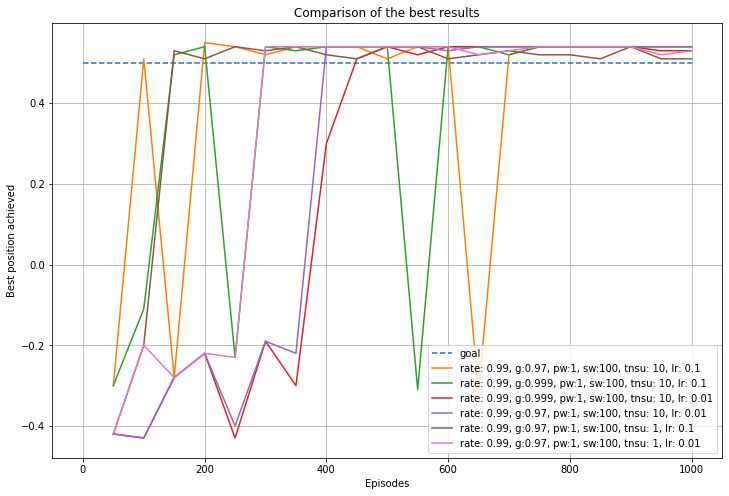

In [ ]:
plt.figure(figsize=(12,8))
plt.plot([0,1000],[0.5,0.5], linestyle='dashed', label = 'goal')
for item in best:
    plt.plot(np.arange(50, 1001, 50), item[4], label = item[0])
# plt.plot([0,1000],[0.5,0.5], linestyle='dashed')
plt.grid()
plt.title('Comparison of the best results')
plt.xlabel('Episodes')
plt.ylabel('Best position achieved')
plt.legend()
plt.savefig('position_car.png')
plt.show()

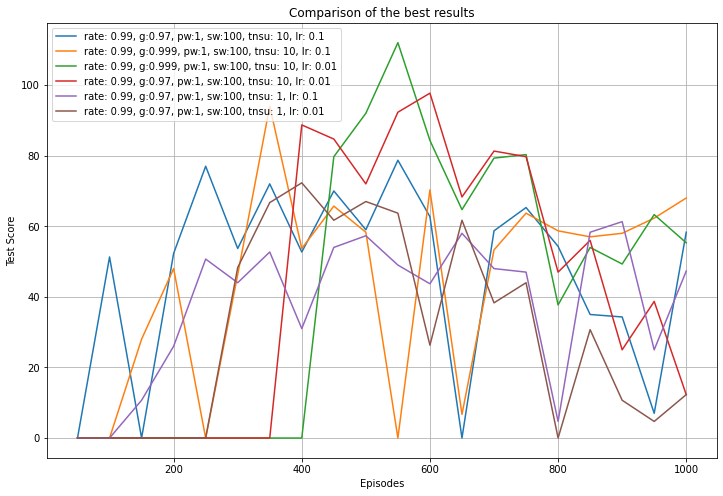

In [ ]:
plt.figure(figsize=(12,8))
for item in best:
    plt.plot(np.arange(50, 1001, 50), item[3], label = item[0])
plt.grid()
plt.title('Comparison of the best results')
plt.xlabel('Episodes')
plt.ylabel('Test Score')
plt.legend()
plt.savefig('score_car.png')
plt.show()

## Final Test: best avg score

In [ ]:
# rate: 0.99, g:0.999, pw:1, sw:100, tnsu: 10, lr: 0.01
# 'rate: 0.99, g:0.97, pw:1, sw:100, tnsu: 10, lr: 0.1
score_log, position_log, ep_num, policy_net = main(iter=1000, gamma=0.97, replay_memory_capacity=5000, lr=0.1, target_net_update_steps=10, 
                        bad_state_penalty=0, strategy='right_speed', exp_policy='softmax', initial_value=1,
                        rate=0.99, period=0, pos_weight=1, speed_weight=100)

After 50 training episodes, average test score: 0.0, best position: -0.30
After 100 training episodes, average test score: 51.3, best position: 0.51
After 150 training episodes, average test score: 0.0, best position: -0.28
After 200 training episodes, average test score: 52.3, best position: 0.55
After 250 training episodes, average test score: 77.0, best position: 0.54
After 300 training episodes, average test score: 53.7, best position: 0.52
After 350 training episodes, average test score: 72.0, best position: 0.54
After 400 training episodes, average test score: 52.7, best position: 0.54
After 450 training episodes, average test score: 70.0, best position: 0.54
After 500 training episodes, average test score: 59.0, best position: 0.51
After 550 training episodes, average test score: 78.7, best position: 0.54
After 600 training episodes, average test score: 62.7, best position: 0.54
After 650 training episodes, average test score: 0.0, best position: -0.32
After 700 training episode

In [ ]:
# TEST WITH VIDEO! IT DOES NOT NEED ADDITIONAL OUTPUT FROM THE TRAINING LOOP
env = gym.make('MountainCar-v0') 
env.seed(0) # Set a random seed for the environment (reproducible results)
score_log = []

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode

for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 200
    best_position = -0.5
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
        # Choose the best action (temperature 0)
        action, q_values = choose_action_softmax(policy_net, state, temperature=0)
        # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
        next_state, reward, done, info = env.step(action)
        new_position = next_state[0]
        if new_position > best_position:
            best_position = new_position
        # Visually render the environment
        env.render()
        # Here it makes no sense to change the reward
        # Update the final score (+1 for each step)
        score -= 1 # or +=1
        # Set the current state for the next iteration
        state = next_state
        # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"TEST EPISODE {num_episode + 1} - FINAL SCORE: {score} - position: {best_position}") 
    # print(f"TEST EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
    score_log.append(score)
    position_log.append(best_position)
avg_score = np.mean(score_log)
max_position = np.max(position_log)
# print(f'Average test score (over 5 runs): {avg_score:.1f}')
print(f'Average test score: {avg_score:.1f}, best position: {max_position:.2f}')
# test_score_log.append(avg_score)
env.close()

TEST EPISODE 1 - FINAL SCORE: 54 - position: 0.5368577983788596
TEST EPISODE 2 - FINAL SCORE: 59 - position: 0.5368577983788596
TEST EPISODE 3 - FINAL SCORE: 61 - position: 0.5368577983788596
TEST EPISODE 4 - FINAL SCORE: 59 - position: 0.5368577983788596
TEST EPISODE 5 - FINAL SCORE: 55 - position: 0.5368577983788596
TEST EPISODE 6 - FINAL SCORE: 60 - position: 0.5368577983788596
TEST EPISODE 7 - FINAL SCORE: 60 - position: 0.5368577983788596
TEST EPISODE 8 - FINAL SCORE: 60 - position: 0.5368577983788596
TEST EPISODE 9 - FINAL SCORE: 54 - position: 0.5368577983788596
TEST EPISODE 10 - FINAL SCORE: 61 - position: 0.5368577983788596
Average test score: 58.3, best position: 0.55


In [ ]:
# Display the videos, not required outside Colab
show_videos()


SHOWING VIDEO video/openaigym.video.4.61.video000000.mp4



SHOWING VIDEO video/openaigym.video.4.61.video000001.mp4



SHOWING VIDEO video/openaigym.video.4.61.video000002.mp4



SHOWING VIDEO video/openaigym.video.4.61.video000003.mp4



SHOWING VIDEO video/openaigym.video.4.61.video000004.mp4



SHOWING VIDEO video/openaigym.video.4.61.video000005.mp4



SHOWING VIDEO video/openaigym.video.4.61.video000006.mp4



SHOWING VIDEO video/openaigym.video.4.61.video000007.mp4



SHOWING VIDEO video/openaigym.video.4.61.video000008.mp4



SHOWING VIDEO video/openaigym.video.4.61.video000009.mp4


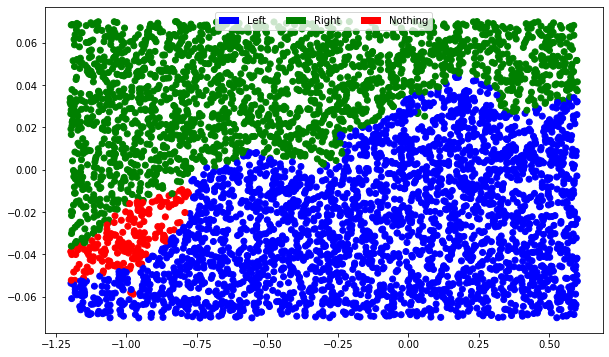

In [ ]:
# Learned policy plot
pos = np.random.uniform(-1.2, 0.6, 5000)
vel = np.random.uniform(-0.07, 0.07, 5000)
col = []

colors = {0: 'b', 1: 'r', 2: 'g'}

for i in range(5000):
    action, q_values = choose_action_softmax(policy_net, (pos[i], vel[i]), temperature=0)
    col.append(colors[action])
    
labels = ['Left','Right','Nothing']
plt.figure(figsize = (10, 6))
plt.scatter(pos, vel, c = col, label=labels)
recs = []
for i in range(0,3):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=sorted(colors.values())[i]))
labels = ['Left','Right','Nothing']
plt.legend(recs, labels, ncol=3)
plt.savefig('policy_avg.png')
plt.show()

## Final Test: best max score

In [ ]:
# rate: 0.99, g:0.999, pw:1, sw:100, tnsu: 10, lr: 0.01

score_log, position_log, ep_num, policy_net = main(iter=550, gamma=0.999, replay_memory_capacity=5000, lr=0.01, target_net_update_steps=10, 
                        bad_state_penalty=0, strategy='right_speed', exp_policy='softmax', initial_value=1,
                        rate=0.99, period=0, pos_weight=1, speed_weight=100)

After 50 training episodes, average test score: 0.0, best position: -0.42
After 100 training episodes, average test score: 0.0, best position: -0.43
After 150 training episodes, average test score: 0.0, best position: -0.28
After 200 training episodes, average test score: 0.0, best position: -0.22
After 250 training episodes, average test score: 0.0, best position: -0.43
After 300 training episodes, average test score: 0.0, best position: -0.19
After 350 training episodes, average test score: 0.0, best position: -0.30
After 400 training episodes, average test score: 0.0, best position: 0.30
After 450 training episodes, average test score: 79.7, best position: 0.51
After 500 training episodes, average test score: 92.0, best position: 0.54
After 550 training episodes, average test score: 112.0, best position: 0.52

Best score: 112.0, best position: 0.5368577983788596


In [ ]:
# TEST WITH VIDEO! IT DOES NOT NEED ADDITIONAL OUTPUT FROM THE TRAINING LOOP
env = gym.make('MountainCar-v0') 
env.seed(0) # Set a random seed for the environment (reproducible results)
score_log = []

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode

for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 200
    best_position = -0.5
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
        # Choose the best action (temperature 0)
        action, q_values = choose_action_softmax(policy_net, state, temperature=0)
        # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
        next_state, reward, done, info = env.step(action)
        new_position = next_state[0]
        if new_position > best_position:
            best_position = new_position
        # Visually render the environment
        env.render()
        # Here it makes no sense to change the reward
        # Update the final score (+1 for each step)
        score -= 1 # or +=1
        # Set the current state for the next iteration
        state = next_state
        # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"TEST EPISODE {num_episode + 1} - FINAL SCORE: {score} - position: {best_position}") 
    # print(f"TEST EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
    score_log.append(score)
    position_log.append(best_position)
avg_score = np.mean(score_log)
max_position = np.max(position_log)
# print(f'Average test score (over 5 runs): {avg_score:.1f}')
print(f'Average test score: {avg_score:.1f}, best position: {max_position:.2f}')
# test_score_log.append(avg_score)
env.close()

TEST EPISODE 1 - FINAL SCORE: 88 - position: 0.5368577983788596
TEST EPISODE 2 - FINAL SCORE: 116 - position: 0.5186574945235085
TEST EPISODE 3 - FINAL SCORE: 96 - position: 0.510759366502282
TEST EPISODE 4 - FINAL SCORE: 49 - position: 0.5368577983788596
TEST EPISODE 5 - FINAL SCORE: 88 - position: 0.5368577983788596
TEST EPISODE 6 - FINAL SCORE: 103 - position: 0.5046353978906463
TEST EPISODE 7 - FINAL SCORE: 46 - position: 0.5368577983788596
TEST EPISODE 8 - FINAL SCORE: 102 - position: 0.5138906508398895
TEST EPISODE 9 - FINAL SCORE: 88 - position: 0.5368577983788596
TEST EPISODE 10 - FINAL SCORE: 35 - position: 0.5368577983788596
Average test score: 81.1, best position: 0.54


In [ ]:
# Display the videos, not required outside Colab
show_videos()


SHOWING VIDEO video/openaigym.video.3.61.video000000.mp4



SHOWING VIDEO video/openaigym.video.3.61.video000001.mp4



SHOWING VIDEO video/openaigym.video.3.61.video000002.mp4



SHOWING VIDEO video/openaigym.video.3.61.video000003.mp4



SHOWING VIDEO video/openaigym.video.3.61.video000004.mp4



SHOWING VIDEO video/openaigym.video.3.61.video000005.mp4



SHOWING VIDEO video/openaigym.video.3.61.video000006.mp4



SHOWING VIDEO video/openaigym.video.3.61.video000007.mp4



SHOWING VIDEO video/openaigym.video.3.61.video000008.mp4



SHOWING VIDEO video/openaigym.video.3.61.video000009.mp4


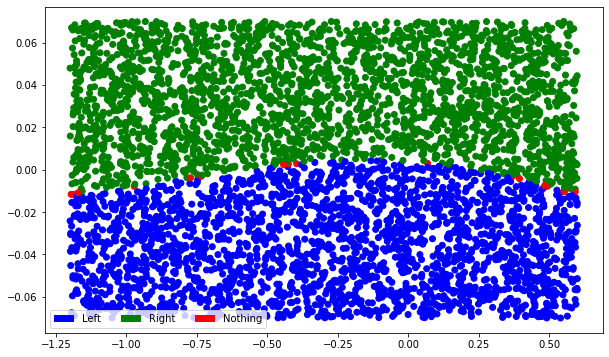

In [ ]:
# Learned policy plot
pos = np.random.uniform(-1.2, 0.6, 5000)
vel = np.random.uniform(-0.07, 0.07, 5000)
col = []

colors = {0: 'b', 1: 'r', 2: 'g'}

for i in range(5000):
    action, q_values = choose_action_softmax(policy_net, (pos[i], vel[i]), temperature=0)
    col.append(colors[action])
    
labels = ['Left','Right','Nothing']
plt.figure(figsize = (10, 6))
plt.scatter(pos, vel, c = col, label=labels)
recs = []
for i in range(0,3):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=sorted(colors.values())[i]))
labels = ['Left','Right','Nothing']
plt.legend(recs, labels, ncol=3)
plt.savefig('policy_max.png')
plt.show()